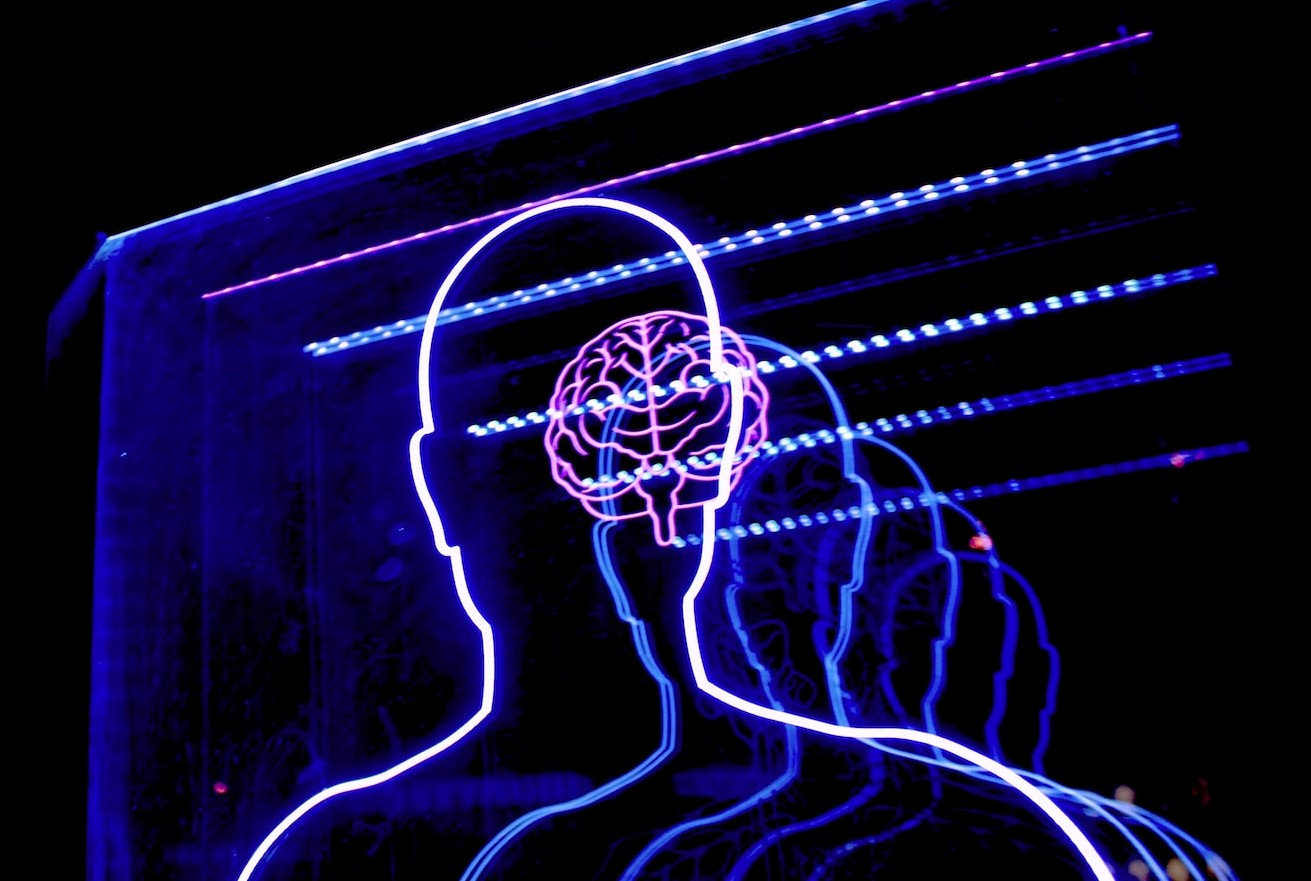

# Import packages

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score 
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import eli5
from eli5.sklearn import PermutationImportance

# Import data and examine

In [2]:
df = pd.read_csv('../input/dementia-prediction-dataset/dementia_dataset.csv')

In [3]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [4]:
df.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


# Data cleaning

In [5]:
df.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

#### Replace missing values with the mean

In [6]:
df = df.fillna(df.mean())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


#### Tidy up Subject ID and MRI ID columns

In [7]:
list = df['Subject ID']
newlist = []
for number in range (len(df)):
    newlist.append(list[number][-3:])
df['Subject ID'] = newlist

In [8]:
list1 = df['MRI ID']
newlist1 = []
for number in range (len(df)):
    newlist1.append(list1[number][-1:])
df['MRI ID'] = newlist1

#### Replace M/F columns with Male

In [9]:
df['Male'] = [value for value in df['M/F'] == 'M']
df = df.drop (columns = ['M/F'])

#### Drop Hand column as all values are R

In [10]:
df = df.drop (columns = ['Hand'])

# Preparing the 'Group' target column

In [11]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Male
0,001,1,Nondemented,1,0,87,14,2.000000,27.0,0.0,1987,0.696,0.883,True
1,001,2,Nondemented,2,457,88,14,2.000000,30.0,0.0,2004,0.681,0.876,True
2,002,1,Demented,1,0,75,12,2.460452,23.0,0.5,1678,0.736,1.046,True
3,002,2,Demented,2,560,76,12,2.460452,28.0,0.5,1738,0.713,1.010,True
4,002,3,Demented,3,1895,80,12,2.460452,22.0,0.5,1698,0.701,1.034,True


#### How many unique subjects are there?

In [12]:
print ("Number of unique subjects = ",len(df['Subject ID'].unique()))

Number of unique subjects =  150


#### Examine the target column

<AxesSubplot:xlabel='Group', ylabel='count'>

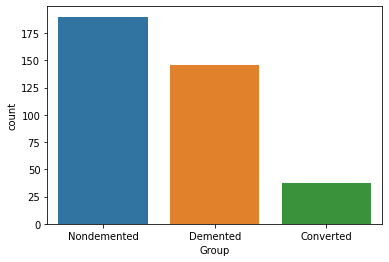

In [13]:
sns.countplot(x = df['Group'])

In [14]:
df.Group.value_counts()

Nondemented    190
Demented       146
Converted       37
Name: Group, dtype: int64

#### All records with CDR score = 1.0 or 2.0 have dementia. All nondemented patients have CDR score 0.0.

In [15]:
df.groupby('Group')['CDR'].value_counts()

Group        CDR
Converted    0.5     19
             0.0     18
Demented     0.5    102
             1.0     41
             2.0      3
Nondemented  0.0    188
             0.5      2
Name: CDR, dtype: int64

#### All Converted can be classed as Demented so let's create a new column to group these together

In [16]:
df['Nondemented'] = [value for value in df['Group'] == 'Nondemented']
df = df.drop(columns = ['Group'])

# Correlations with the target

In [17]:
df.corr()['Nondemented'].sort_values(ascending = False)

Nondemented    1.000000
MMSE           0.523305
nWBV           0.311346
EDUC           0.193060
MR Delay       0.120638
Visit          0.095507
eTIV           0.042700
Age            0.005941
ASF           -0.032495
SES           -0.060697
Male          -0.222146
CDR           -0.778049
Name: Nondemented, dtype: float64

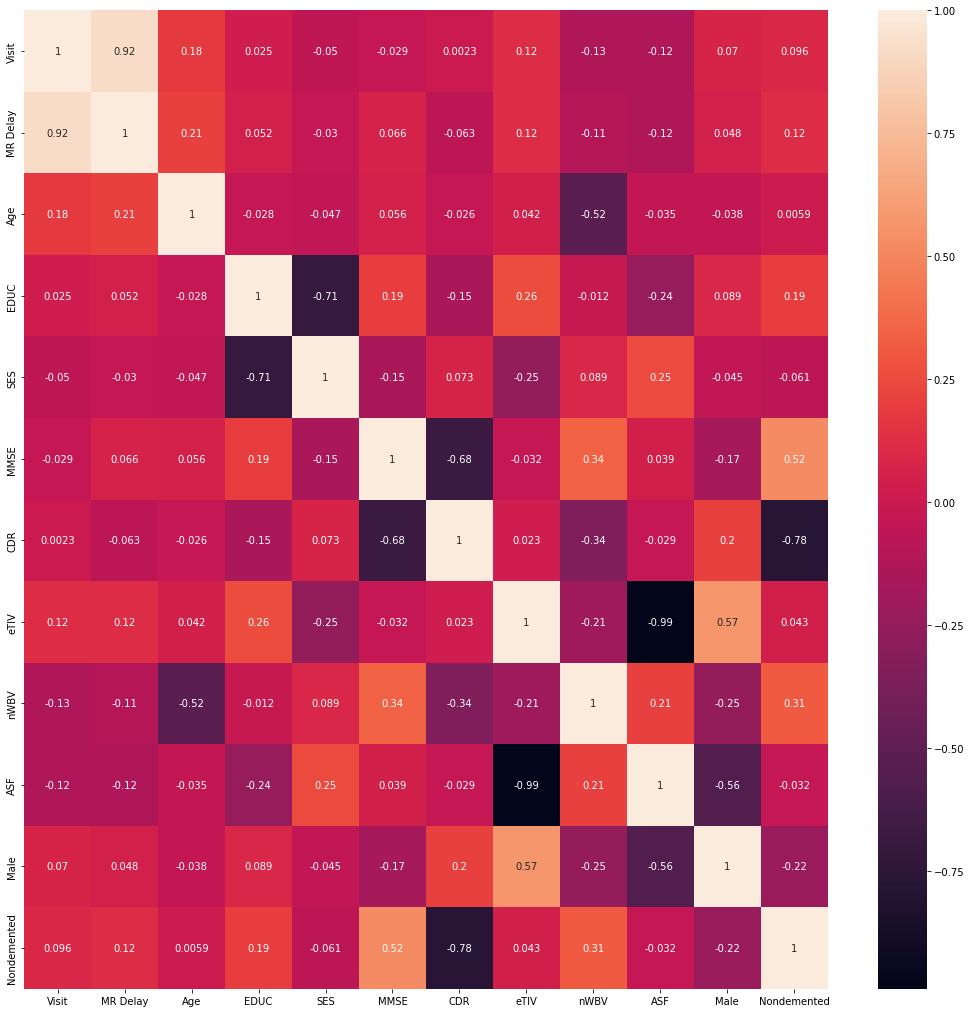

In [18]:
plt.figure(1 , figsize = (18 , 18))
cor = sns.heatmap(df.corr(), annot = True)

# Instantiate classifier

In [19]:
# Parameters tuned separately
clf = xgb.XGBClassifier(n_estimators =20, max_depth = 3)

In [20]:
# To prevent error messages
df['Subject ID'] = df['Subject ID'].astype(int)
df['MRI ID'] = df['MRI ID'].astype(int)

In [21]:
X = df.drop(columns = 'Nondemented')

In [22]:
y = df['Nondemented']

# Cross validation score

In [23]:
print(cross_val_score(clf, X, y, scoring='accuracy'))
print(cross_val_score(clf, X, y, scoring='accuracy').mean())

[0.92       0.96       0.97333333 0.91891892 0.94594595]
0.9436396396396397


# Test performance on a sample

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 12)

In [26]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=20, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [27]:
clf.score(X_test, y_test)

0.9893617021276596

# Interpreting the model

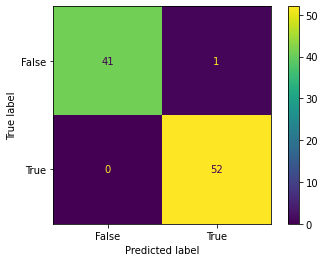

In [28]:
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

In [29]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

CDR           0.747064
MMSE          0.053436
Age           0.034176
nWBV          0.032962
eTIV          0.030475
MR Delay      0.028460
SES           0.027899
Subject ID    0.025995
EDUC          0.019534
MRI ID        0.000000
Visit         0.000000
ASF           0.000000
Male          0.000000
dtype: float32

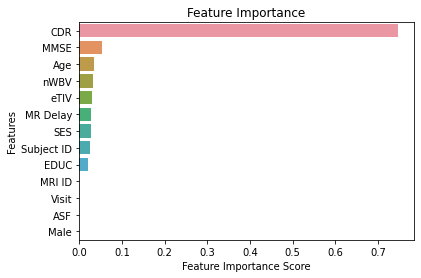

In [30]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.show()

In [31]:
perm = PermutationImportance(clf).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.4287 ± 0.0728,CDR
0.0222 ± 0.0084,eTIV
0.0143 ± 0.0064,Age
0.0143 ± 0.0064,Subject ID
0.0115 ± 0.0105,MR Delay
0.0036 ± 0.0045,nWBV
0.0036 ± 0.0045,EDUC
0.0029 ± 0.0070,MMSE
0.0029 ± 0.0070,SES
0 ± 0.0000,Male
